#### By: Peyman Shahidi
#### Created: Oct 16, 2025
#### Last Edit: Oct 16, 2025

<br>

In [45]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [46]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [47]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [48]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop DWA columns
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# # Drop original Task ID and Task Title columns
# ONET = ONET.drop(columns=['Task ID', 'Task Title'])
# # Rename DWA ID and DWA Title to Task ID and Task Title
# ONET = ONET.rename(columns={'DWA ID': 'Task ID', 'DWA Title': 'Task Title'})

# Remove duplicate rows based on Occupation Title and new Task ID
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates(subset=['Occupation Title', 'Task ID']).reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


Level: Major Group — groups: 22
Level: Minor Group — groups: 95
Level: Broad Occupation — groups: 430
Level: Detailed Occupation — groups: 759


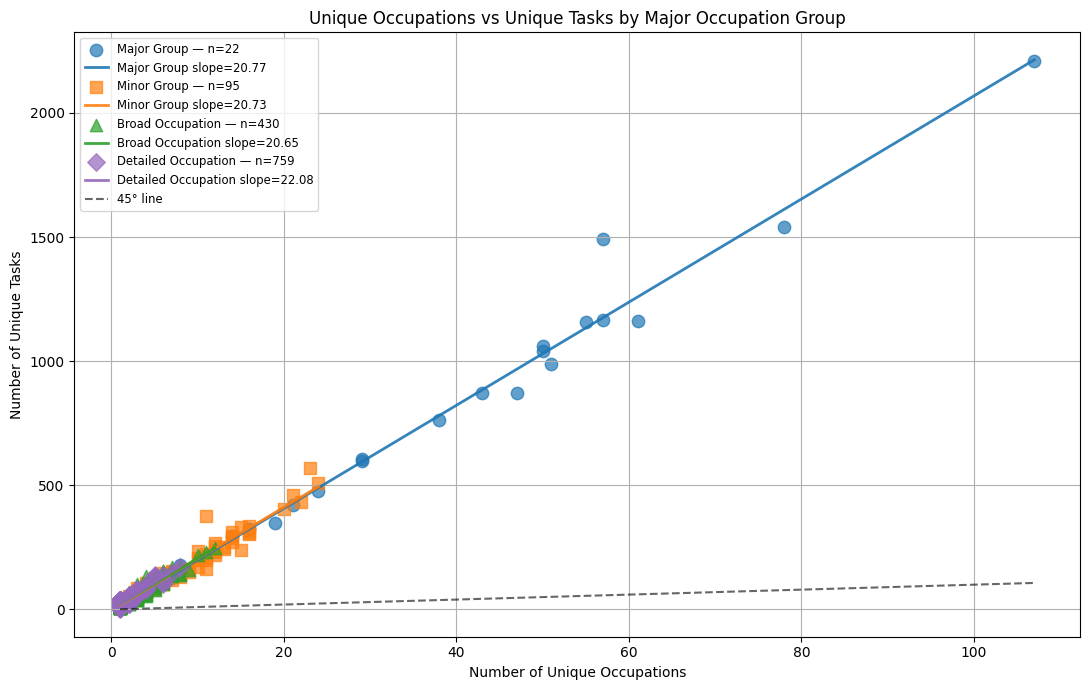

In [49]:
# Compute group-level counts for multiple industry levels and plot them together

levels = [
    ("Major_Group_Title", "Major_Group_Code", "Major Group"),
    ("Minor_Group_Title", "Minor_Group_Code", "Minor Group"),
    ("Broad_Occupation_Title", "Broad_Occupation_Code", "Broad Occupation"),
    ("Detailed_Occupation_Title", "Detailed_Occupation_Code", "Detailed Occupation"),
]

# Detect which of these column pairs actually exist in the ONET dataframe
available_levels = []
for title_col, code_col, label in levels:
    if title_col in ONET.columns and code_col in ONET.columns:
        available_levels.append((title_col, code_col, label))
    else:
        print(f"Skipping {label}: columns '{title_col}' / '{code_col}' not found in ONET")

if not available_levels:
    raise RuntimeError("No matching industry level columns found in ONET. Check column names.")

from numpy.polynomial.polynomial import polyfit

grouped_stats = {}
for title_col, code_col, label in available_levels:
    industry_df = ONET[["O*NET-SOC Code", "Occupation Title", "Task ID", "Task Title", code_col, title_col]].drop_duplicates()
    industry_grouped = industry_df.groupby([code_col, title_col]).agg(
        num_unique_occupations=("O*NET-SOC Code", "nunique"),
        num_unique_tasks=("Task ID", "nunique")
    ).reset_index()
    print(f"Level: {label} — groups: {len(industry_grouped):,}")
    grouped_stats[label] = industry_grouped

# Plotting (multiple levels on same figure)
plt.figure(figsize=(11, 7))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]
markers = ["o", "s", "^", "D"]

# Determine global plotting range (use x-range only for 45° line)
all_x_mins = []
all_x_maxs = []
all_y_mins = []
all_y_maxs = []
for df in grouped_stats.values():
    all_x_mins.append(df['num_unique_occupations'].min())
    all_x_maxs.append(df['num_unique_occupations'].max())
    all_y_mins.append(df['num_unique_tasks'].min())
    all_y_maxs.append(df['num_unique_tasks'].max())

# Use x extents to define the 45-degree line range
global_x_min = min(all_x_mins)
global_x_max = max(all_x_maxs)
# Use global y extents for axis limits but do not extend the 45° line beyond x extents
global_y_min = min(all_y_mins)
global_y_max = max(all_y_maxs)

for i, label in enumerate(grouped_stats.keys()):
    g = grouped_stats[label]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]

    # scatter: label shows count
    plt.scatter(g['num_unique_occupations'], g['num_unique_tasks'],
                color=color, s=80, alpha=0.7, marker=marker,
                label=f"{label} — n={len(g):,}")

    # Fitted line (only if there is variation in x); label shows slope
    try:
        if len(g) >= 2 and g['num_unique_occupations'].nunique() > 1:
            b, m = polyfit(g['num_unique_occupations'], g['num_unique_tasks'], 1)
            x_fit = np.linspace(g['num_unique_occupations'].min(), g['num_unique_occupations'].max(), 100)
            y_fit = b + m * x_fit
            plt.plot(x_fit, y_fit, color=color, linewidth=2, alpha=0.9, label=f"{label} slope={m:.2f}")
        else:
            print(f"Skipping fit for {label}: not enough variation in num_unique_occupations")
    except Exception as e:
        print(f"Fit failed for {label}: {e}")

# 45-degree line
plt.plot([global_x_min, global_x_max], [global_x_min, global_x_max], 'k--', linewidth=1.5, alpha=0.6, label='45° line')

plt.xlabel('Number of Unique Occupations')
plt.ylabel('Number of Unique Tasks')
plt.title('Unique Occupations vs Unique Tasks by Major Occupation Group')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
# plt.savefig(f'{output_plot_path}/unique_occupations_vs_tasks_all_levels.png', dpi=300)
plt.show()

In [50]:
def compute_grouped_stats(df, use_shuffled=False):
    """
    Compute grouped statistics for different occupation hierarchy levels.
    Returns a dictionary with statistics for each available level.
    
    Parameters:
    - df: DataFrame to analyze
    - use_shuffled: If True, use the shuffled/assigned columns. If False, use original columns.
    """
    if use_shuffled:
        # Use shuffled/assigned columns
        levels = [
            ("Major_Assigned_Title", "Major_Assigned_Code", "Major Group"),
            ("Minor_Assigned_Title", "Minor_Assigned_Code", "Minor Group"),
            ("Broad_Assigned_Title", "Broad_Assigned_Code", "Broad Occupation"), 
            ("Detailed_Assigned_Title", "Detailed_Assigned_Code", "Detailed Occupation"),
        ]
        onet_col = "O*NET_Assigned_Code"
        occupation_col = "O*NET_Assigned_Title"
    else:
        # Use original columns
        levels = [
            ("Major_Group_Title", "Major_Group_Code", "Major Group"),
            ("Minor_Group_Title", "Minor_Group_Code", "Minor Group"), 
            ("Broad_Occupation_Title", "Broad_Occupation_Code", "Broad Occupation"),
            ("Detailed_Occupation_Title", "Detailed_Occupation_Code", "Detailed Occupation"),
        ]
        onet_col = "O*NET-SOC Code"
        occupation_col = "Occupation Title"
    
    # Detect which columns actually exist in the dataframe
    available_levels = []
    for title_col, code_col, label in levels:
        if title_col in df.columns and code_col in df.columns:
            available_levels.append((title_col, code_col, label))
    
    if not available_levels:
        print(f"Warning: No matching hierarchy level columns found in dataframe (use_shuffled={use_shuffled})")
        return {}
    
    grouped_stats = {}
    
    for title_col, code_col, label in available_levels:
        industry_df = df[[onet_col, occupation_col, "Task ID", "Task Title", code_col, title_col]].drop_duplicates()
        industry_grouped = industry_df.groupby([code_col, title_col]).agg(
            num_unique_occupations=(onet_col, "nunique"),
            num_unique_tasks=("Task ID", "nunique")
        ).reset_index()
        
        grouped_stats[label] = industry_grouped
    
    return grouped_stats

Pools — majors: 22, minors: 110, broads: 431, detailed: 759, onet: 873, tasks: 17,953
Overall x-range: 1 to 108; y-range: 4 to 2214
Overall x-range: 1 to 108; y-range: 4 to 2214


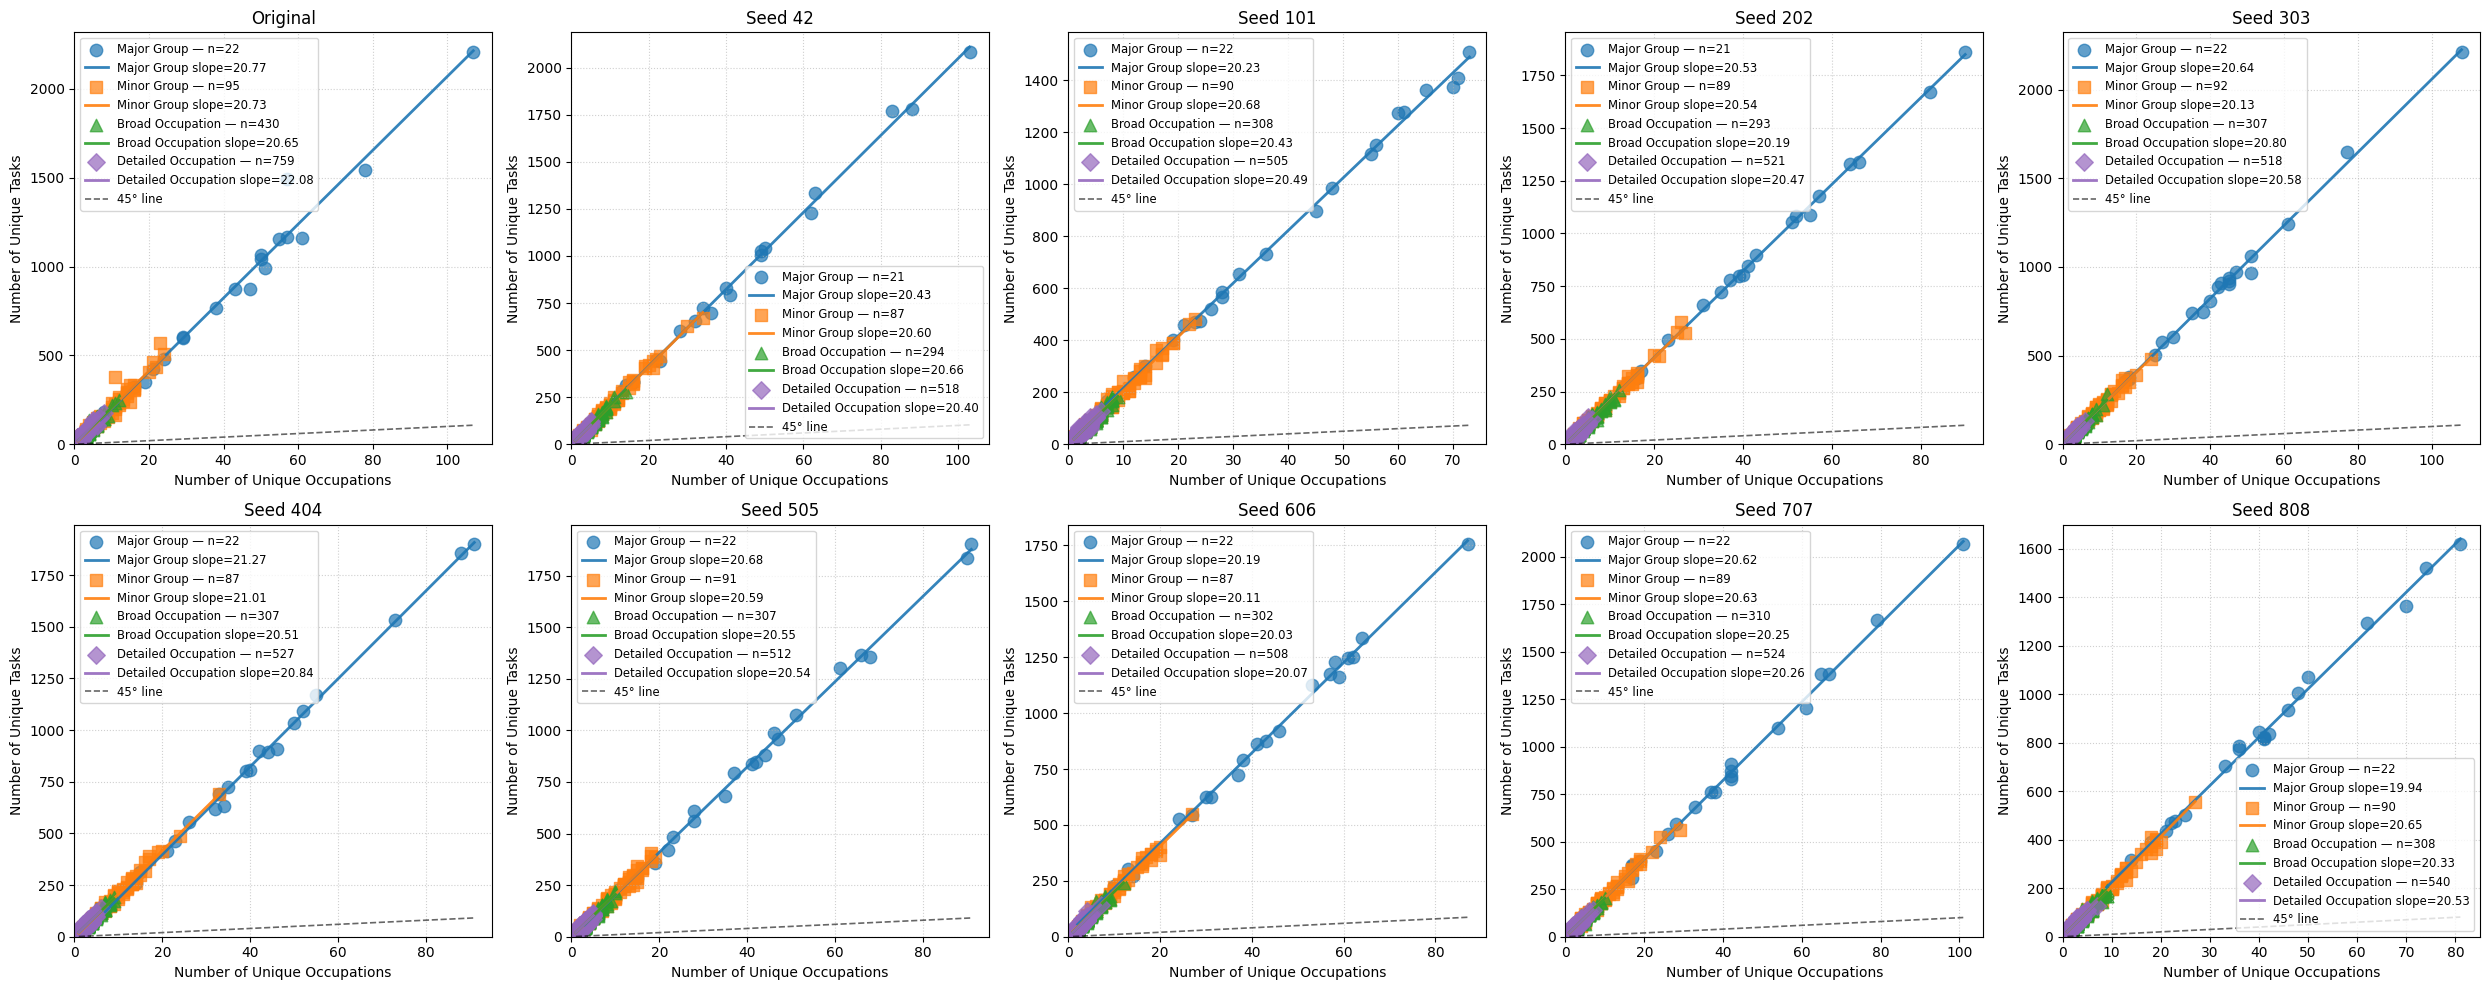


Looking up assigned unit for O*NET code: 11-1011.00

Original units (unique rows):
Major_Group_Code Minor_Group_Code Broad_Occupation_Code Detailed_Occupation_Code O*NET-SOC Code Occupation Title
         11-0000          11-1000               11-1010                  11-1011     11-1011.00 Chief Executives
Original: unique tasks associated with 11-1011.00: 31
Seed 42: Major=45-0000 (Farming, Fishing, and Forestry Occupations), Minor=25-1000 (Postsecondary Teachers), Broad=43-3050 (Payroll and Timekeeping Clerks), Detailed=49-2098 (Security and Fire Alarm Systems Installers), O*NET=11-1011.00 (Chief Executives) — tasks mapped: 19
Seed 101: Major=31-0000 (Healthcare Support Occupations), Minor=25-1100 (nan), Broad=39-1010 (First-Line Supervisors of Entertainment and Recreation Workers), Detailed=53-6011 (Bridge and Lock Tenders), O*NET=11-1011.00 (Chief Executives) — tasks mapped: 26
Seed 202: Major=29-0000 (Healthcare Practitioners and Technical Occupations), Minor=53-1000 (Supervisor

In [51]:
# Multi-seed hierarchical reshuffle per your specification (Original + 9 seeds -> 2x5 grid)
# Seeds (9 seeds)
seeds = [42, 101, 202, 303, 404, 505, 606, 707, 808]

# Identify code/title columns if present
code_cols = {
    'major_code': 'Major_Group_Code', 'major_title': 'Major_Group_Title',
    'minor_code': 'Minor_Group_Code', 'minor_title': 'Minor_Group_Title',
    'broad_code': 'Broad_Occupation_Code', 'broad_title': 'Broad_Occupation_Title',
    'detailed_code': 'Detailed_Occupation_Code', 'detailed_title': 'Detailed_Occupation_Title',
    'onet_code': 'O*NET-SOC Code', 'onet_title': 'Occupation Title'
}

present = {k: v for k, v in code_cols.items() if v in ONET.columns}

required_codes = ['minor_code', 'broad_code', 'detailed_code', 'onet_code']
missing = [c for c in required_codes if c not in present]
if missing:
    raise RuntimeError(f'Missing required columns for hierarchical reshuffle: {missing}')

# Build pools of unique codes
major_codes = ONET[present.get('major_code')].dropna().astype(str).unique().tolist() if 'major_code' in present else []
minor_codes = ONET[present['minor_code']].dropna().astype(str).unique().tolist()
broad_codes = ONET[present['broad_code']].dropna().astype(str).unique().tolist()
detailed_codes = ONET[present['detailed_code']].dropna().astype(str).unique().tolist()
onet_codes = ONET[present['onet_code']].dropna().astype(str).unique().tolist()
unique_tasks = ONET[['Task ID', 'Task Title']].drop_duplicates().reset_index(drop=True)

print(f'Pools — majors: {len(major_codes):,}, minors: {len(minor_codes):,}, broads: {len(broad_codes):,}, detailed: {len(detailed_codes):,}, onet: {len(onet_codes):,}, tasks: {len(unique_tasks):,}')

# helper dicts for code->title (when titles exist)
code_to_title = {}
for prefix, col in [('major', 'major_code'), ('minor', 'minor_code'), ('broad', 'broad_code'), ('detailed', 'detailed_code'), ('onet', 'onet_code')]:
    if prefix + '_title' in present:
        src_code = present[prefix + '_code']
        src_title = present[prefix + '_title']
        code_to_title[prefix] = ONET[[src_code, src_title]].drop_duplicates().set_index(src_code)[src_title].to_dict()
    else:
        code_to_title[prefix] = {}


def create_hierarchical_shuffled_df(seed):
    """Build mappings: minor->major, broad->minor, detailed->broad, onet->detailed,
    then treat each unique (major, minor, broad, detailed, onet) as a unit and
    assign tasks randomly to units (with replacement). Returns a reshuffled ONET df and units table."""
    rng = np.random.default_rng(seed)

    # If no majors present, create dummy majors pool so minors can map
    majors_pool = major_codes if major_codes else ['MAJOR_0']

    # Map each minor to a random major (each minor is matched)
    minor_to_major = {m: rng.choice(majors_pool) for m in minor_codes}

    # Map each broad to a random minor
    broad_to_minor = {b: rng.choice(minor_codes) for b in broad_codes}

    # Map each detailed to a random broad
    detailed_to_broad = {d: rng.choice(broad_codes) for d in detailed_codes}

    # Map each onet code to a random detailed
    onet_to_detailed = {o: rng.choice(detailed_codes) for o in onet_codes}

    # Build per-onet unit tuple by chaining mappings
    unit_records = []
    for o in onet_codes:
        assigned_detailed = onet_to_detailed[o]
        assigned_broad = detailed_to_broad[assigned_detailed]
        assigned_minor = broad_to_minor[assigned_broad]
        assigned_major = minor_to_major[assigned_minor]

        rec = {
            'Major_Assigned_Code': assigned_major,
            'Minor_Assigned_Code': assigned_minor,
            'Broad_Assigned_Code': assigned_broad,
            'Detailed_Assigned_Code': assigned_detailed,
            'O*NET_Assigned_Code': o
        }
        # attach titles if available
        if 'major' in code_to_title and rec['Major_Assigned_Code'] in code_to_title['major']:
            rec['Major_Assigned_Title'] = code_to_title['major'][rec['Major_Assigned_Code']]
        else:
            rec['Major_Assigned_Title'] = str(rec['Major_Assigned_Code'])
        if 'minor' in code_to_title and rec['Minor_Assigned_Code'] in code_to_title['minor']:
            rec['Minor_Assigned_Title'] = code_to_title['minor'][rec['Minor_Assigned_Code']]
        else:
            rec['Minor_Assigned_Title'] = str(rec['Minor_Assigned_Code'])
        if 'broad' in code_to_title and rec['Broad_Assigned_Code'] in code_to_title['broad']:
            rec['Broad_Assigned_Title'] = code_to_title['broad'][rec['Broad_Assigned_Code']]
        else:
            rec['Broad_Assigned_Title'] = str(rec['Broad_Assigned_Code'])
        if 'detailed' in code_to_title and rec['Detailed_Assigned_Code'] in code_to_title['detailed']:
            rec['Detailed_Assigned_Title'] = code_to_title['detailed'][rec['Detailed_Assigned_Code']]
        else:
            rec['Detailed_Assigned_Title'] = str(rec['Detailed_Assigned_Code'])
        # occupation title for onet
        if 'onet' in code_to_title and o in code_to_title['onet']:
            rec['O*NET_Assigned_Title'] = code_to_title['onet'][o]
        else:
            rec['O*NET_Assigned_Title'] = str(o)

        unit_records.append(rec)

    units_df = pd.DataFrame(unit_records).drop_duplicates().reset_index(drop=True)
    # Now assign tasks to units randomly (with replacement) — this changes counts per unit
    num_units = len(units_df)
    if num_units == 0:
        raise RuntimeError('No units produced during hierarchical mapping (check input columns).')

    task_unit_idx = rng.integers(low=0, high=num_units, size=len(unique_tasks))
    units_sampled = units_df.loc[task_unit_idx].reset_index(drop=True)
    task_to_unit = pd.concat([unique_tasks.reset_index(drop=True), units_sampled], axis=1).set_index('Task ID')

    # Apply mapping to full ONET dataset by Task ID
    df_shuf = ONET.copy().reset_index(drop=True)
    # ensure Task ID has same type as unique_tasks index
    df_shuf['Task ID'] = df_shuf['Task ID']
    # assign the new unit columns (use assigned names)
    for col in ['Major_Assigned_Code', 'Major_Assigned_Title', 'Minor_Assigned_Code', 'Minor_Assigned_Title',
                'Broad_Assigned_Code', 'Broad_Assigned_Title', 'Detailed_Assigned_Code', 'Detailed_Assigned_Title',
                'O*NET_Assigned_Code', 'O*NET_Assigned_Title']:
        df_shuf[col] = df_shuf['Task ID'].map(lambda t: task_to_unit.loc[t, col])

    return df_shuf, units_df


# Run for original and each seed; store grouped stats and full reshuffled dfs
results = {}
results['Original'] = compute_grouped_stats(ONET, use_shuffled=False)
units_per_seed = {}
shuffled_dfs = {}
for s in seeds:
    df_s, units_df = create_hierarchical_shuffled_df(s)
    shuffled_dfs[s] = df_s
    results[f'Seed {s}'] = compute_grouped_stats(df_s, use_shuffled=True)
    units_per_seed[s] = units_df


# Compute overall extents for plotting
def get_extents_all(results_dict):
    x_mins, x_maxs, y_mins, y_maxs = [], [], [], []
    for stats in results_dict.values():
        for df in stats.values():
            if len(df) == 0:
                continue
            x_mins.append(df['num_unique_occupations'].min())
            x_maxs.append(df['num_unique_occupations'].max())
            y_mins.append(df['num_unique_tasks'].min())
            y_maxs.append(df['num_unique_tasks'].max())
    return (min(x_mins) if x_mins else 0, max(x_maxs) if x_maxs else 1,
            min(y_mins) if y_mins else 0, max(y_maxs) if y_maxs else 1)

oxmin, oxmax, oymin, oymax = get_extents_all(results)
print(f'Overall x-range: {oxmin} to {oxmax}; y-range: {oymin} to {oymax}')

# Plot Original + each seed in a 2 x 5 grid (Original + 9 seeds = 10 panels)
n_plots = 1 + len(seeds)
ncols = 5
nrows = 2
if n_plots != ncols * nrows:
    # fallback to a single row if layout doesn't exactly match
    fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 6), sharex=False, sharey=False)
    if n_plots == 1:
        axes = [axes]
else:
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()

for ax_idx, (label, stats) in enumerate(results.items()):
    ax = axes[ax_idx]
    handles = []
    labels_leg = []
    
    # Calculate individual extents for this specific dataset
    x_mins_local = []
    x_maxs_local = []
    y_mins_local = []
    y_maxs_local = []
    
    for lvl in stats.keys():
        g = stats[lvl]
        if len(g) > 0:
            x_mins_local.append(g['num_unique_occupations'].min())
            x_maxs_local.append(g['num_unique_occupations'].max())
            y_mins_local.append(g['num_unique_tasks'].min())
            y_maxs_local.append(g['num_unique_tasks'].max())
    
    if x_mins_local:  # Only proceed if we have data
        local_x_min = min(x_mins_local)
        local_x_max = max(x_maxs_local)
        local_y_min = min(y_mins_local)
        local_y_max = max(y_maxs_local)
    else:
        local_x_min, local_x_max = 0, 1
        local_y_min, local_y_max = 0, 1
    
    for i, lvl in enumerate(stats.keys()):
        g = stats[lvl]
        color = ["tab:blue", "tab:orange", "tab:green", "tab:purple"][i % 4]
        marker = ["o", "s", "^", "D"][i % 4]
        sc = ax.scatter(g['num_unique_occupations'], g['num_unique_tasks'], color=color, s=80, alpha=0.7, marker=marker)
        handles.append(sc)
        labels_leg.append(f"{lvl} — n={len(g):,}")
        try:
            if len(g) >= 2 and g['num_unique_occupations'].nunique() > 1:
                b, m = polyfit(g['num_unique_occupations'], g['num_unique_tasks'], 1)
                x_fit = np.linspace(g['num_unique_occupations'].min(), g['num_unique_occupations'].max(), 100)
                y_fit = b + m * x_fit
                ln, = ax.plot(x_fit, y_fit, color=color, linewidth=2, alpha=0.9)
                handles.append(ln)
                labels_leg.append(f"{lvl} slope={m:.2f}")
        except Exception as e:
            print(f"Fit failed for {lvl} in {label}: {e}")

    # Use local extents for 45-degree line
    l45, = ax.plot([local_x_min, local_x_max], [local_x_min, local_x_max], 'k--', linewidth=1.2, alpha=0.6)
    handles.append(l45)
    labels_leg.append('45° line')

    # Use local extents for axis limits
    x_padding = max(1, int((local_x_max - local_x_min) * 0.05))
    y_padding = max(1, int((local_y_max - local_y_min) * 0.05))
    ax.set_xlim(max(0, local_x_min - x_padding), local_x_max + x_padding)
    ax.set_ylim(max(0, local_y_min - y_padding), local_y_max + y_padding)
    ax.set_xlabel('Number of Unique Occupations')
    ax.set_ylabel('Number of Unique Tasks')
    ax.set_title(label)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(handles, labels_leg, fontsize='small')

plt.tight_layout()
# plt.savefig(f'{output_plot_path}/hierarchical_original_and_seeds.png', dpi=300)
plt.show()

# --- Print assigned unit for a target O*NET code across seeds ---
TARGET_ONET = "11-1011.00"
print(f"\nLooking up assigned unit for O*NET code: {TARGET_ONET}\n")

# Original units (may be multiple rows)
orig_rows = ONET[ONET['O*NET-SOC Code'].astype(str) == TARGET_ONET]
if len(orig_rows) == 0:
    print(f"Original dataset: O*NET code {TARGET_ONET} not found.")
else:
    cols_to_show = []
    for k in ['major_code', 'minor_code', 'broad_code', 'detailed_code', 'onet_code']:
        if k in present:
            cols_to_show.append(present[k])
    cols_to_show.append('Occupation Title')
    print("Original units (unique rows):")
    print(orig_rows[cols_to_show].drop_duplicates().to_string(index=False))
    # print number of unique tasks in original for this code
    orig_task_count = ONET[ONET['O*NET-SOC Code'].astype(str) == TARGET_ONET][['Task ID']].drop_duplicates().shape[0]
    print(f"Original: unique tasks associated with {TARGET_ONET}: {orig_task_count}")

# For each seed, find the unit row in units_per_seed and task counts
for s in seeds:
    units_df = units_per_seed[s]
    # ensure string comparison
    match = units_df[units_df['O*NET_Assigned_Code'].astype(str) == TARGET_ONET]
    df_s = shuffled_dfs[s]
    # count unique tasks mapped to this assigned onet in the reshuffled df
    task_counts = df_s[['Task ID', 'O*NET_Assigned_Code']].drop_duplicates()
    n_tasks = int((task_counts['O*NET_Assigned_Code'].astype(str) == TARGET_ONET).sum())
    if len(match) == 0:
        print(f"Seed {s}: O*NET {TARGET_ONET} not present in generated units. Tasks mapped to this code: {n_tasks}")
    else:
        r = match.iloc[0]
        print(f"Seed {s}: Major={r['Major_Assigned_Code']} ({r.get('Major_Assigned_Title','')}), Minor={r['Minor_Assigned_Code']} ({r.get('Minor_Assigned_Title','')}), Broad={r['Broad_Assigned_Code']} ({r.get('Broad_Assigned_Title','')}), Detailed={r['Detailed_Assigned_Code']} ({r.get('Detailed_Assigned_Title','')}), O*NET={r['O*NET_Assigned_Code']} ({r.get('O*NET_Assigned_Title','')}) — tasks mapped: {n_tasks}")


Seed 42 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 101 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 101 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 202 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 202 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 303 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 303 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 404 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 404 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 505 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 505 - Bias targets: Major=11-0000, Minor=11-1000, Broad=11-1010, Detailed=11-1011
Seed 606 - Bias targets: Major=11-0000, Mino

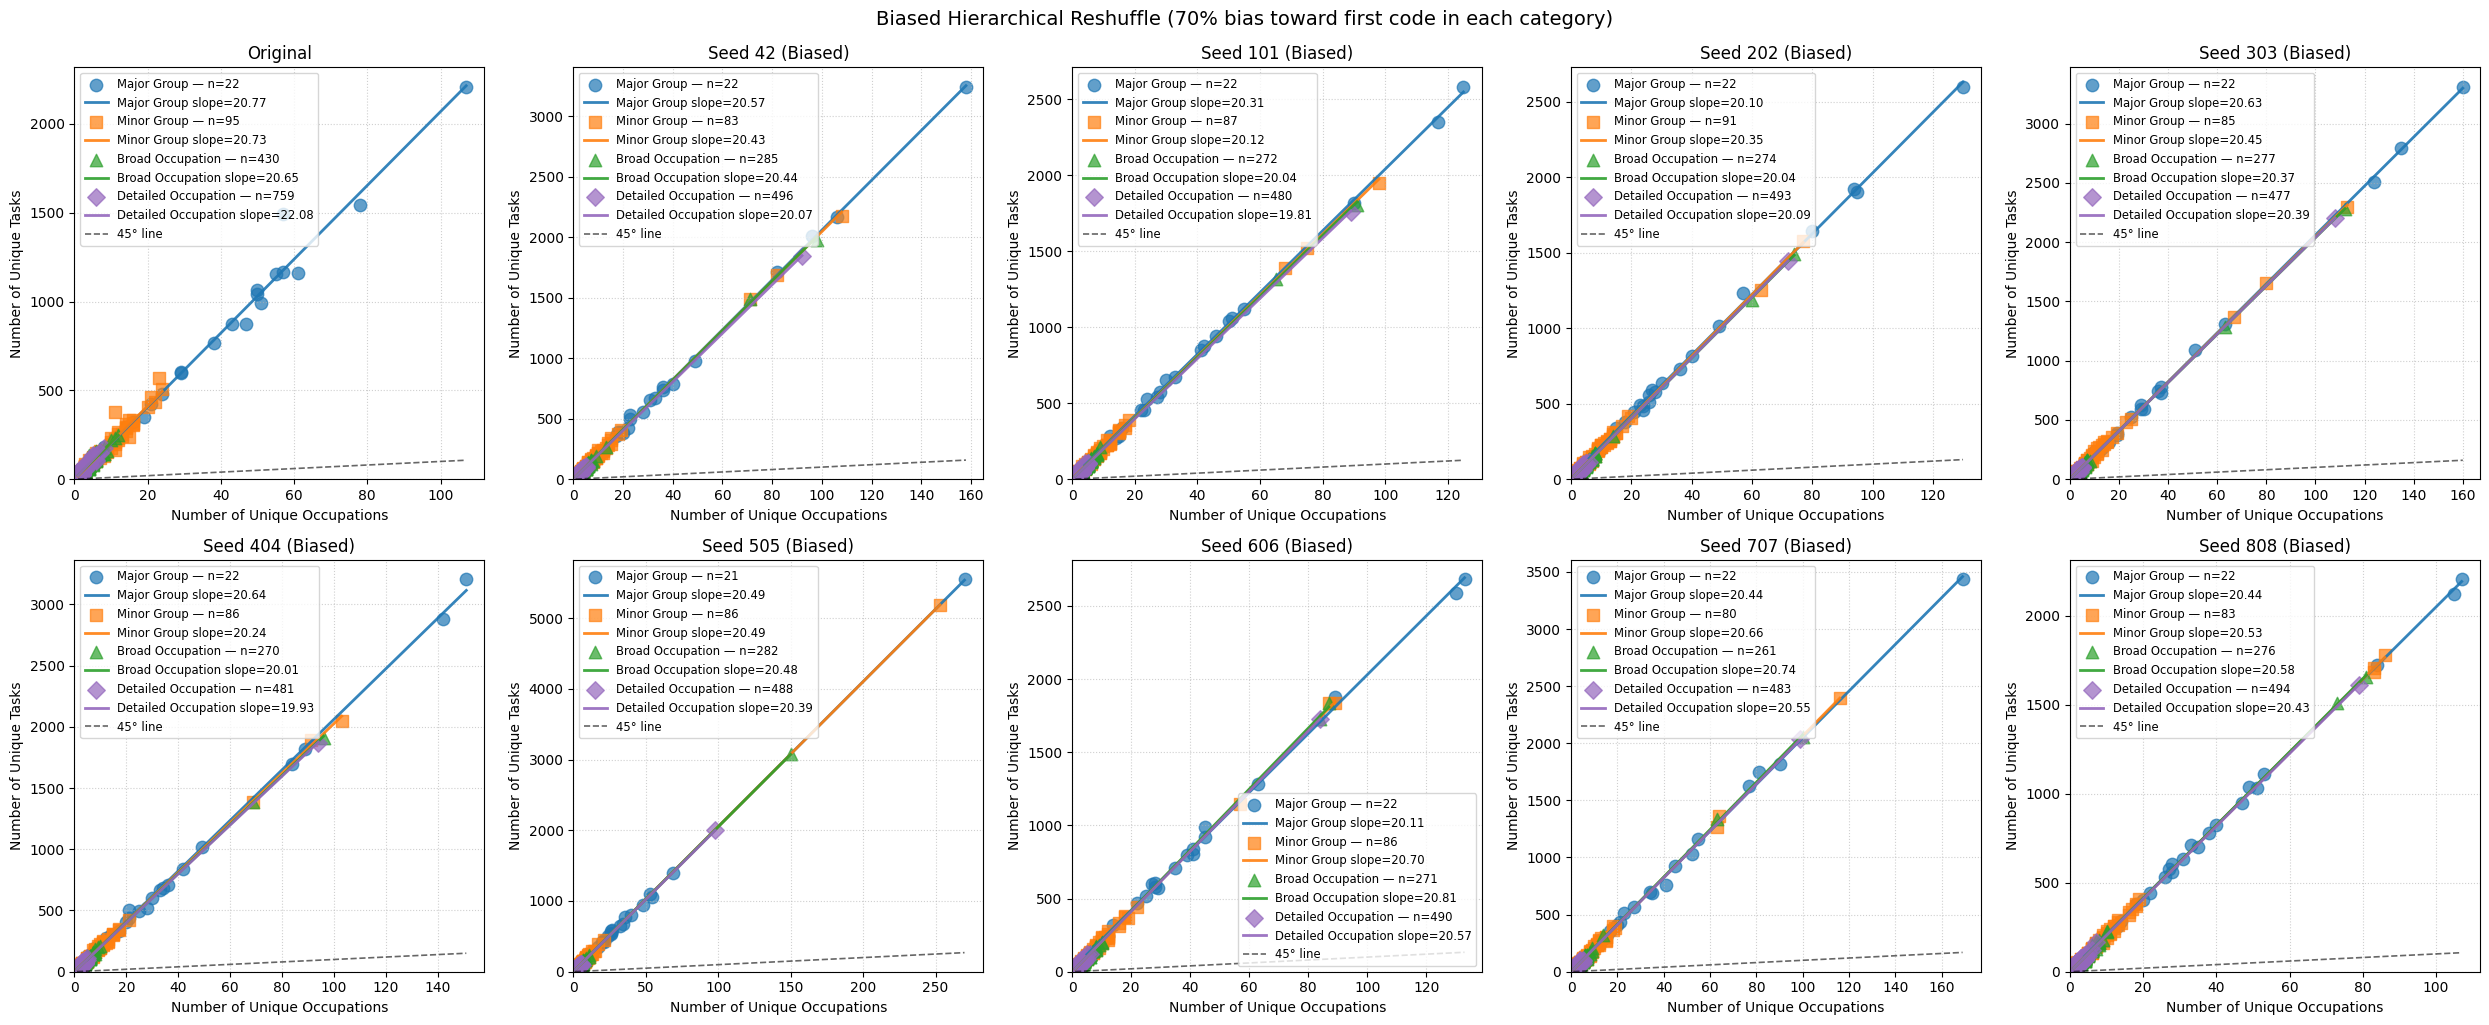


Comparison of bias effects:
Regular randomization x-range: 1 to 108
Biased randomization x-range: 1 to 270
Regular randomization y-range: 4 to 2214
Biased randomization y-range: 4 to 5547


In [52]:
# Biased hierarchical reshuffle - preferentially assign to specific target codes
# This will create clustering effects by biasing assignments toward specific codes

# Same seeds for comparison
seeds_biased = [42, 101, 202, 303, 404, 505, 606, 707, 808]

def create_biased_hierarchical_shuffled_df(seed, bias_strength=0.1):
    """
    Build mappings with bias toward specific target codes in each hierarchy level.
    
    Parameters:
    - seed: random seed
    - bias_strength: probability of assigning to target code (0.5 = no bias, 1.0 = always assign to target)
    """
    rng = np.random.default_rng(seed)

    # Select target codes (use the first code in each category as target)
    majors_pool = major_codes if major_codes else ['MAJOR_0']
    target_major = majors_pool[0] if majors_pool else 'MAJOR_0'
    target_minor = minor_codes[0] if minor_codes else None
    target_broad = broad_codes[0] if broad_codes else None
    target_detailed = detailed_codes[0] if detailed_codes else None
    
    print(f"Seed {seed} - Bias targets: Major={target_major}, Minor={target_minor}, Broad={target_broad}, Detailed={target_detailed}")

    # Biased mapping: each minor to major (with bias toward target_major)
    minor_to_major = {}
    for m in minor_codes:
        if rng.random() < bias_strength:
            minor_to_major[m] = target_major
        else:
            # Choose randomly from remaining majors (or target if only one exists)
            available_majors = [maj for maj in majors_pool if maj != target_major]
            if available_majors:
                minor_to_major[m] = rng.choice(available_majors)
            else:
                minor_to_major[m] = target_major

    # Biased mapping: each broad to minor (with bias toward target_minor)
    broad_to_minor = {}
    for b in broad_codes:
        if rng.random() < bias_strength:
            broad_to_minor[b] = target_minor
        else:
            available_minors = [min_code for min_code in minor_codes if min_code != target_minor]
            if available_minors:
                broad_to_minor[b] = rng.choice(available_minors)
            else:
                broad_to_minor[b] = target_minor

    # Biased mapping: each detailed to broad (with bias toward target_broad)
    detailed_to_broad = {}
    for d in detailed_codes:
        if rng.random() < bias_strength:
            detailed_to_broad[d] = target_broad
        else:
            available_broads = [broad for broad in broad_codes if broad != target_broad]
            if available_broads:
                detailed_to_broad[d] = rng.choice(available_broads)
            else:
                detailed_to_broad[d] = target_broad

    # Biased mapping: each onet to detailed (with bias toward target_detailed)
    onet_to_detailed = {}
    for o in onet_codes:
        if rng.random() < bias_strength:
            onet_to_detailed[o] = target_detailed
        else:
            available_detailed = [det for det in detailed_codes if det != target_detailed]
            if available_detailed:
                onet_to_detailed[o] = rng.choice(available_detailed)
            else:
                onet_to_detailed[o] = target_detailed

    # Build per-onet unit tuple by chaining mappings
    unit_records = []
    for o in onet_codes:
        assigned_detailed = onet_to_detailed[o]
        assigned_broad = detailed_to_broad[assigned_detailed]
        assigned_minor = broad_to_minor[assigned_broad]
        assigned_major = minor_to_major[assigned_minor]

        rec = {
            'Major_Assigned_Code': assigned_major,
            'Minor_Assigned_Code': assigned_minor,
            'Broad_Assigned_Code': assigned_broad,
            'Detailed_Assigned_Code': assigned_detailed,
            'O*NET_Assigned_Code': o
        }
        # attach titles if available
        if 'major' in code_to_title and rec['Major_Assigned_Code'] in code_to_title['major']:
            rec['Major_Assigned_Title'] = code_to_title['major'][rec['Major_Assigned_Code']]
        else:
            rec['Major_Assigned_Title'] = str(rec['Major_Assigned_Code'])
        if 'minor' in code_to_title and rec['Minor_Assigned_Code'] in code_to_title['minor']:
            rec['Minor_Assigned_Title'] = code_to_title['minor'][rec['Minor_Assigned_Code']]
        else:
            rec['Minor_Assigned_Title'] = str(rec['Minor_Assigned_Code'])
        if 'broad' in code_to_title and rec['Broad_Assigned_Code'] in code_to_title['broad']:
            rec['Broad_Assigned_Title'] = code_to_title['broad'][rec['Broad_Assigned_Code']]
        else:
            rec['Broad_Assigned_Title'] = str(rec['Broad_Assigned_Code'])
        if 'detailed' in code_to_title and rec['Detailed_Assigned_Code'] in code_to_title['detailed']:
            rec['Detailed_Assigned_Title'] = code_to_title['detailed'][rec['Detailed_Assigned_Code']]
        else:
            rec['Detailed_Assigned_Title'] = str(rec['Detailed_Assigned_Code'])
        # occupation title for onet
        if 'onet' in code_to_title and o in code_to_title['onet']:
            rec['O*NET_Assigned_Title'] = code_to_title['onet'][o]
        else:
            rec['O*NET_Assigned_Title'] = str(o)

        unit_records.append(rec)

    units_df = pd.DataFrame(unit_records).drop_duplicates().reset_index(drop=True)
    
    # Now assign tasks to units randomly (with replacement) — this changes counts per unit
    num_units = len(units_df)
    if num_units == 0:
        raise RuntimeError('No units produced during hierarchical mapping (check input columns).')

    task_unit_idx = rng.integers(low=0, high=num_units, size=len(unique_tasks))
    units_sampled = units_df.loc[task_unit_idx].reset_index(drop=True)
    task_to_unit = pd.concat([unique_tasks.reset_index(drop=True), units_sampled], axis=1).set_index('Task ID')

    # Apply mapping to full ONET dataset by Task ID
    df_shuf = ONET.copy().reset_index(drop=True)
    # ensure Task ID has same type as unique_tasks index
    df_shuf['Task ID'] = df_shuf['Task ID']
    # assign the new unit columns (use assigned names)
    for col in ['Major_Assigned_Code', 'Major_Assigned_Title', 'Minor_Assigned_Code', 'Minor_Assigned_Title',
                'Broad_Assigned_Code', 'Broad_Assigned_Title', 'Detailed_Assigned_Code', 'Detailed_Assigned_Title',
                'O*NET_Assigned_Code', 'O*NET_Assigned_Title']:
        df_shuf[col] = df_shuf['Task ID'].map(lambda t: task_to_unit.loc[t, col])

    return df_shuf, units_df


# Run biased reshuffling for original and each seed
results_biased = {}
results_biased['Original'] = compute_grouped_stats(ONET, use_shuffled=False)
units_per_seed_biased = {}
shuffled_dfs_biased = {}

for s in seeds_biased:
    df_s, units_df = create_biased_hierarchical_shuffled_df(s, bias_strength=0.1)
    shuffled_dfs_biased[s] = df_s
    results_biased[f'Seed {s} (Biased)'] = compute_grouped_stats(df_s, use_shuffled=True)
    units_per_seed_biased[s] = units_df

# Compute overall extents for biased plotting
oxmin_biased, oxmax_biased, oymin_biased, oymax_biased = get_extents_all(results_biased)
print(f'\nBiased - Overall x-range: {oxmin_biased} to {oxmax_biased}; y-range: {oymin_biased} to {oymax_biased}')

# Plot Original + each biased seed in a 2 x 5 grid
n_plots_biased = 1 + len(seeds_biased)
ncols = 5
nrows = 2
if n_plots_biased != ncols * nrows:
    fig_biased, axes_biased = plt.subplots(1, n_plots_biased, figsize=(5*n_plots_biased, 6), sharex=False, sharey=False)
    if n_plots_biased == 1:
        axes_biased = [axes_biased]
else:
    fig_biased, axes_biased = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes_biased = axes_biased.flatten()

for ax_idx, (label, stats) in enumerate(results_biased.items()):
    ax = axes_biased[ax_idx]
    handles = []
    labels_leg = []
    
    # Calculate individual extents for this specific dataset
    x_mins_local = []
    x_maxs_local = []
    y_mins_local = []
    y_maxs_local = []
    
    for lvl in stats.keys():
        g = stats[lvl]
        if len(g) > 0:
            x_mins_local.append(g['num_unique_occupations'].min())
            x_maxs_local.append(g['num_unique_occupations'].max())
            y_mins_local.append(g['num_unique_tasks'].min())
            y_maxs_local.append(g['num_unique_tasks'].max())
    
    if x_mins_local:  # Only proceed if we have data
        local_x_min = min(x_mins_local)
        local_x_max = max(x_maxs_local)
        local_y_min = min(y_mins_local)
        local_y_max = max(y_maxs_local)
    else:
        local_x_min, local_x_max = 0, 1
        local_y_min, local_y_max = 0, 1
    
    for i, lvl in enumerate(stats.keys()):
        g = stats[lvl]
        color = ["tab:blue", "tab:orange", "tab:green", "tab:purple"][i % 4]
        marker = ["o", "s", "^", "D"][i % 4]
        sc = ax.scatter(g['num_unique_occupations'], g['num_unique_tasks'], color=color, s=80, alpha=0.7, marker=marker)
        handles.append(sc)
        labels_leg.append(f"{lvl} — n={len(g):,}")
        try:
            if len(g) >= 2 and g['num_unique_occupations'].nunique() > 1:
                b, m = polyfit(g['num_unique_occupations'], g['num_unique_tasks'], 1)
                x_fit = np.linspace(g['num_unique_occupations'].min(), g['num_unique_occupations'].max(), 100)
                y_fit = b + m * x_fit
                ln, = ax.plot(x_fit, y_fit, color=color, linewidth=2, alpha=0.9)
                handles.append(ln)
                labels_leg.append(f"{lvl} slope={m:.2f}")
        except Exception as e:
            print(f"Fit failed for {lvl} in {label}: {e}")

    # Use local extents for 45-degree line
    l45, = ax.plot([local_x_min, local_x_max], [local_x_min, local_x_max], 'k--', linewidth=1.2, alpha=0.6)
    handles.append(l45)
    labels_leg.append('45° line')

    # Use local extents for axis limits
    x_padding = max(1, int((local_x_max - local_x_min) * 0.05))
    y_padding = max(1, int((local_y_max - local_y_min) * 0.05))
    ax.set_xlim(max(0, local_x_min - x_padding), local_x_max + x_padding)
    ax.set_ylim(max(0, local_y_min - y_padding), local_y_max + y_padding)
    ax.set_xlabel('Number of Unique Occupations')
    ax.set_ylabel('Number of Unique Tasks')
    ax.set_title(label)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend(handles, labels_leg, fontsize='small')

plt.tight_layout()
plt.suptitle('Biased Hierarchical Reshuffle (10% bias toward first code in each category)', y=1.02, fontsize=14)
# plt.savefig(f'{output_plot_path}/hierarchical_biased_original_and_seeds.png', dpi=300)
plt.show()

print(f"\nComparison of bias effects:")
print(f"Regular randomization x-range: {oxmin} to {oxmax}")
print(f"Biased randomization x-range: {oxmin_biased} to {oxmax_biased}")
print(f"Regular randomization y-range: {oymin} to {oymax}")
print(f"Biased randomization y-range: {oymin_biased} to {oymax_biased}")